In [69]:
import torch
import torch_geometric
from torch_geometric import utils
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torch_geometric.nn.models import Node2Vec

from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

from torch_geometric.utils import degree, to_networkx
import networkx as nx

In [2]:
ec_hic = np.load('data/GBM39ec_5k_collapsed_matrix.npy')
hsr_hic = np.load('data/GBM39HSR_5k_collapsed_matrix.npy')

In [3]:
ec_hic = np.load('data/ec_adj_mat.npy')
hsr_hic = np.load('data/hsr_adj_mat.npy')

ec_hic = (ec_hic != 0).astype(int)
hsr_hic = (hsr_hic != 0).astype(int)

In [4]:
ec_df = pd.read_csv('data/ec_cleaned.csv')
hsr_df = pd.read_csv('data/hsr_cleaned.csv')

In [5]:
hsr_feats = torch.tensor(hsr_df[['read_count', 'total_genes']].to_numpy())
hsr_labels = torch.zeros(hsr_feats.shape[0])

ec_feats = torch.tensor(ec_df[['read_count', 'total_genes']].to_numpy())
ec_labels = torch.ones(ec_feats.shape[0])

In [6]:
def hic_to_sparse(hic_mat):
    #adj_mat = np.triu(hic_mat)
    sparse_adj = coo_matrix(hic_mat)

    return utils.from_scipy_sparse_matrix(sparse_adj)

In [7]:
hsr_edge_index, hsr_edge_attr = hic_to_sparse(hsr_hic)
hsr_graph = torch_geometric.data.Data(edge_index = hsr_edge_index, edge_attr = hsr_edge_attr, x = hsr_feats, y = hsr_labels)

ec_edge_index, ec_edge_attr = hic_to_sparse(ec_hic)
ec_graph = torch_geometric.data.Data(edge_index = ec_edge_index, edge_attr = ec_edge_attr, x = ec_feats, y = ec_labels)

In [8]:
x = torch.cat([ec_feats, hsr_feats], dim=0)
hsr_edge_index = hsr_edge_index + ec_labels.shape[0]
edge_index = torch.cat([ec_edge_index, hsr_edge_index], dim=1)
edge_attr = torch.cat([ec_edge_attr, hsr_edge_attr], dim=0)
edge_index, edge_attr = utils.to_undirected(edge_index, edge_attr)
labels = torch.cat([ec_labels, hsr_labels], dim=0)

G = torch_geometric.data.Data(edge_index = edge_index, edge_attr = edge_attr, x = x, y = labels)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
def train_one_epoch(node2vec, optimizer, loader):
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def train_node2vec(G, n_epochs=100, verbose=True):
    node2vec = Node2Vec(edge_index=G.edge_index, embedding_dim=16, walk_length=3, context_size=2, walks_per_node=10, num_negative_samples=1, p = 1, q = 1, sparse=True)
    node2vec = node2vec.to(device)
    G = G.to(device)
    
    loader = node2vec.loader(batch_size=128, shuffle=True)
    #loader.edge_weight = G.edge_attr
    optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

    for epoch in range(1, n_epochs+1):
        loss = train_one_epoch(node2vec, optimizer=optimizer, loader=loader)
        if verbose:
            print(f'Epoch: {epoch}, Loss: {loss:.4f}')

    node2vec.eval()
    return node2vec().detach().cpu()

In [11]:
embeds = train_node2vec(G, n_epochs=200) 

Epoch: 1, Loss: 3.4299
Epoch: 2, Loss: 3.4109
Epoch: 3, Loss: 3.2874
Epoch: 4, Loss: 3.1823
Epoch: 5, Loss: 3.0966
Epoch: 6, Loss: 3.0063
Epoch: 7, Loss: 2.8955
Epoch: 8, Loss: 2.7985
Epoch: 9, Loss: 2.7019
Epoch: 10, Loss: 2.7125
Epoch: 11, Loss: 2.5684
Epoch: 12, Loss: 2.5056
Epoch: 13, Loss: 2.4778
Epoch: 14, Loss: 2.3702
Epoch: 15, Loss: 2.3159
Epoch: 16, Loss: 2.2594
Epoch: 17, Loss: 2.2013
Epoch: 18, Loss: 2.1443
Epoch: 19, Loss: 2.1192
Epoch: 20, Loss: 2.0524
Epoch: 21, Loss: 2.0176
Epoch: 22, Loss: 1.9708
Epoch: 23, Loss: 1.9250
Epoch: 24, Loss: 1.8581
Epoch: 25, Loss: 1.8477
Epoch: 26, Loss: 1.8188
Epoch: 27, Loss: 1.7805
Epoch: 28, Loss: 1.7542
Epoch: 29, Loss: 1.7146
Epoch: 30, Loss: 1.7011
Epoch: 31, Loss: 1.6500
Epoch: 32, Loss: 1.6159
Epoch: 33, Loss: 1.5773
Epoch: 34, Loss: 1.5807
Epoch: 35, Loss: 1.5343
Epoch: 36, Loss: 1.5159
Epoch: 37, Loss: 1.4914
Epoch: 38, Loss: 1.4670
Epoch: 39, Loss: 1.4505
Epoch: 40, Loss: 1.4261
Epoch: 41, Loss: 1.3883
Epoch: 42, Loss: 1.3893
E

In [12]:
feats_and_embeds = torch.cat([embeds, x], dim=1)

In [13]:
X = feats_and_embeds.numpy()
y = G.y.cpu().numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
mdl = LogisticRegression(solver='liblinear')
mdl.fit(X_train, y_train)

preds = mdl.predict(X_test)
print(f'Logistic Regression Accuracy (1 Graph): {(preds == y_test).mean()}')

Logistic Regression Accuracy (1 Graph): 1.0


In [15]:
lgb = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=63,
    learning_rate=0.1,
    n_estimators=500
)

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

[LightGBM] [Info] Number of positive: 173, number of negative: 178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1986
[LightGBM] [Info] Number of data points in the train set: 351, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492877 -> initscore=-0.028492
[LightGBM] [Info] Start training from score -0.028492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [16]:
print(f'LightGBM Accuracy (1 Graph): {(preds == y_test).mean()}')

LightGBM Accuracy (1 Graph): 1.0


In [17]:
embeds = feats_and_embeds
pca = PCA(n_components=2)
pca_embeds = pca.fit_transform(embeds)
pca_embeds.shape

(502, 2)

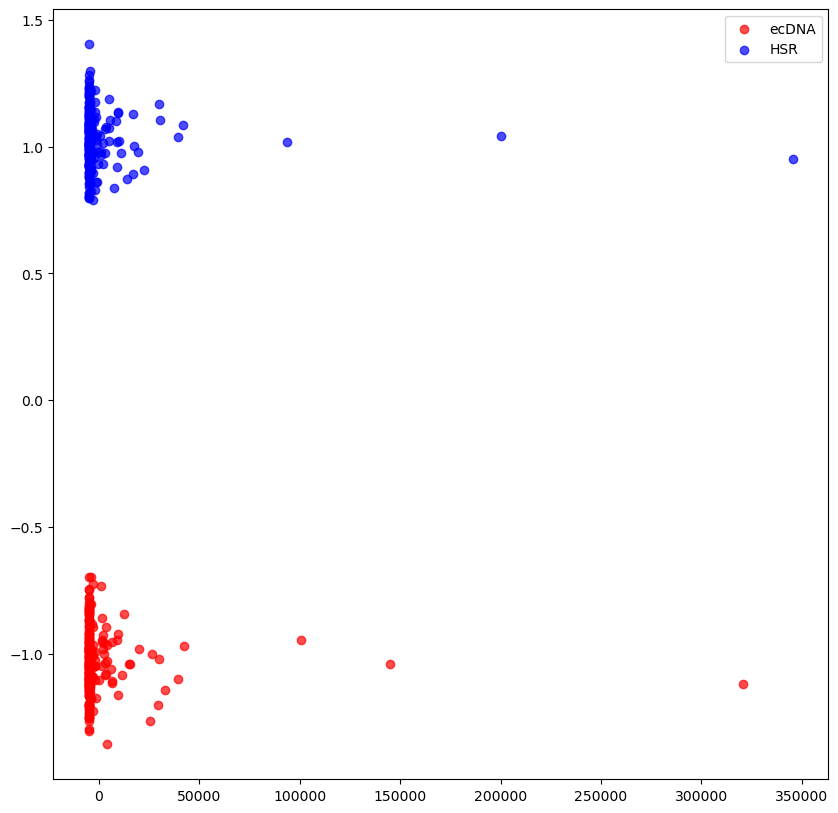

In [18]:
ec_mask = (G.y == 1).cpu()

plt.figure(figsize=(10,10))
plt.scatter(pca_embeds[:, 0][ec_mask], pca_embeds[:, 1][ec_mask], color='red', label='ecDNA', alpha=0.7)
plt.scatter(pca_embeds[:, 0][~ec_mask], pca_embeds[:, 1][~ec_mask], color='blue', label='HSR', alpha=0.7)
plt.legend()
plt.show()

In [19]:
ec_embeds = train_node2vec(ec_graph)
hsr_embeds = train_node2vec(hsr_graph)

Epoch: 1, Loss: 3.5434
Epoch: 2, Loss: 3.5233
Epoch: 3, Loss: 3.3557
Epoch: 4, Loss: 3.3746
Epoch: 5, Loss: 3.2407
Epoch: 6, Loss: 3.2666
Epoch: 7, Loss: 3.1516
Epoch: 8, Loss: 3.1307
Epoch: 9, Loss: 3.0595
Epoch: 10, Loss: 2.9317
Epoch: 11, Loss: 2.9958
Epoch: 12, Loss: 2.8991
Epoch: 13, Loss: 2.8757
Epoch: 14, Loss: 2.8746
Epoch: 15, Loss: 2.7109
Epoch: 16, Loss: 2.7043
Epoch: 17, Loss: 2.6291
Epoch: 18, Loss: 2.5790
Epoch: 19, Loss: 2.5712
Epoch: 20, Loss: 2.5389
Epoch: 21, Loss: 2.4732
Epoch: 22, Loss: 2.4247
Epoch: 23, Loss: 2.4088
Epoch: 24, Loss: 2.3279
Epoch: 25, Loss: 2.3947
Epoch: 26, Loss: 2.2996
Epoch: 27, Loss: 2.2313
Epoch: 28, Loss: 2.2220
Epoch: 29, Loss: 2.2192
Epoch: 30, Loss: 2.2026
Epoch: 31, Loss: 2.1110
Epoch: 32, Loss: 2.1294
Epoch: 33, Loss: 2.0927
Epoch: 34, Loss: 2.0996
Epoch: 35, Loss: 2.0311
Epoch: 36, Loss: 2.0083
Epoch: 37, Loss: 2.0000
Epoch: 38, Loss: 1.9434
Epoch: 39, Loss: 1.9467
Epoch: 40, Loss: 1.9141
Epoch: 41, Loss: 1.8855
Epoch: 42, Loss: 1.9050
E

In [20]:
ec_feats_and_embeds = torch.cat([ec_embeds, ec_feats], dim=1)
hsr_feats_and_embeds = torch.cat([hsr_embeds, hsr_feats], dim=1)

In [21]:
pca = PCA(n_components=2)
ec_pca_embeds = pca.fit_transform(ec_feats_and_embeds)
ec_pca_embeds.shape

(251, 2)

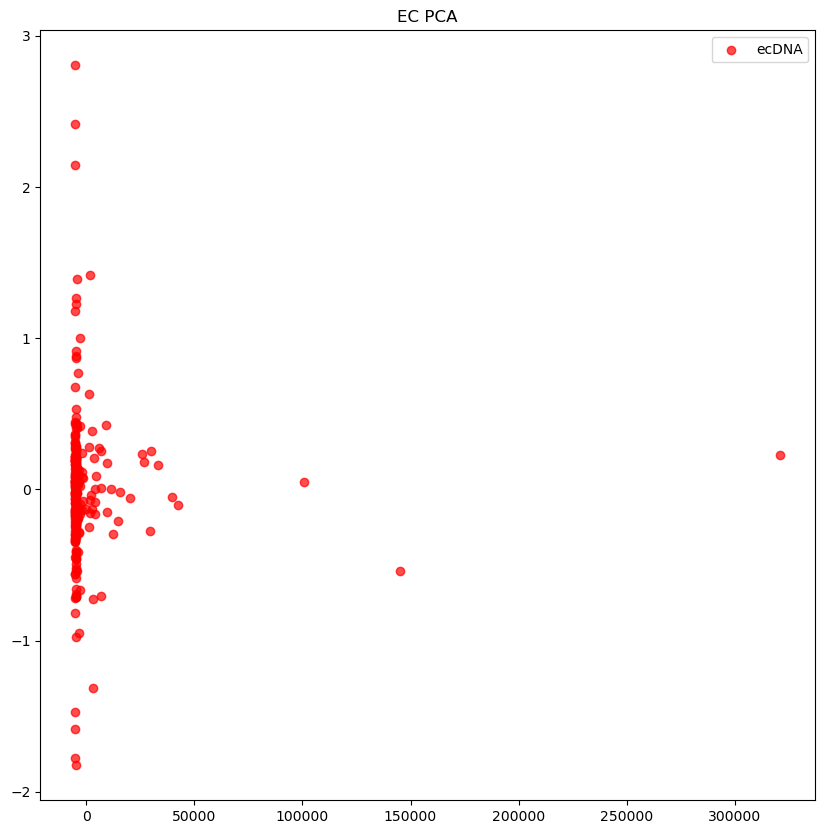

In [102]:
plt.figure(figsize=(10,10))
plt.scatter(ec_pca_embeds[:, 0], ec_pca_embeds[:, 1], color='red', label='ecDNA', alpha=0.7)
plt.title('EC PCA')
plt.legend()
plt.show()

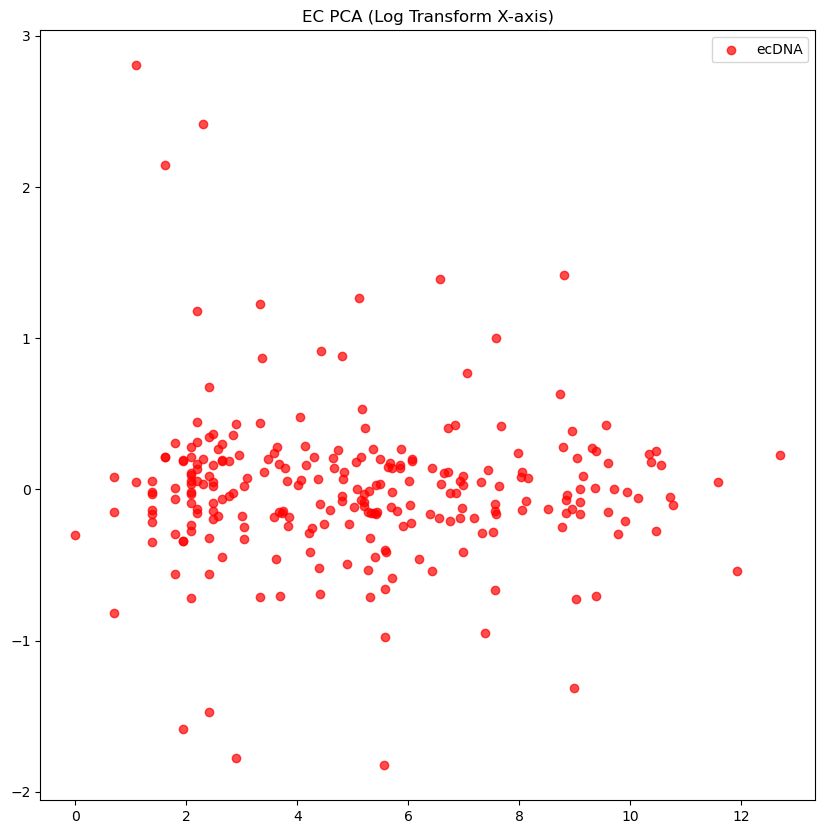

In [103]:
X = ec_pca_embeds.copy()
X[:, 0] = np.log(X[:, 0] - np.min(X[:, 0]) + 1)

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], color='red', label='ecDNA', alpha=0.7)
plt.title('EC PCA (Log Transform X-axis)')
plt.legend()
plt.show()

In [92]:
def km_cluster(embeds, k=4):
    X = embeds.copy()
    X[:, 0] = np.log(X[:, 0] - np.min(X[:, 0]) + 1)

    gamma = 1 / (2 * np.var(X))
    K_rbf = rbf_kernel(X, gamma=gamma)
    
    n_clusters = k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    km_labels = kmeans.fit_predict(K_rbf)
    
    plt.figure(figsize=(8, 6))
    unique_labels = set(km_labels)
    
    for label in unique_labels:
        color = plt.cm.viridis(label / len(unique_labels))
        label_name = f"Cluster {label}"
    
        plt.scatter(
            X[km_labels == label, 0], X[km_labels == label, 1],
            c=[color], label=label_name, edgecolors="k", alpha=0.7
        )
    
    
    plt.legend()
    plt.title(f"KMeans Clustering with RBF Kernel")
    plt.show()

    return km_labels

In [93]:
def db_cluster(embeds, eps=0.1, min_samples=5):
    X = embeds.copy()
    X[:, 0] = np.log(X[:, 0] - np.min(X[:, 0]) + 1)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    db_labels = dbscan.fit_predict(X)
    
    # Plot the clusters
    plt.figure(figsize=(8, 6))
    unique_labels = set(db_labels)
    
    for label in unique_labels:
        if label == -1:
            color = "red" 
            label_name = "Outliers"
        else:
            color = plt.cm.viridis(label / len(unique_labels))
            label_name = f"Cluster {label}"
    
        plt.scatter(
            X[db_labels == label, 0], X[db_labels == label, 1],
            c=[color], label=label_name, edgecolors="k", alpha=0.7
        )
    
    plt.legend()
    plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})")
    plt.show()

    return db_labels

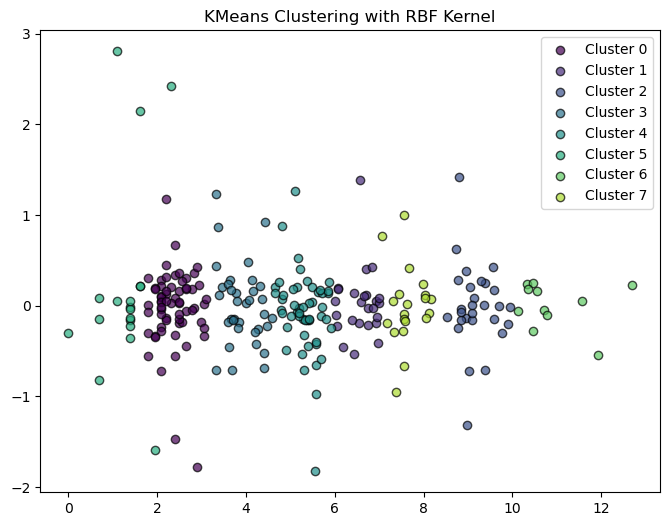

In [97]:
ec_km_labels = km_cluster(ec_pca_embeds, k=8)

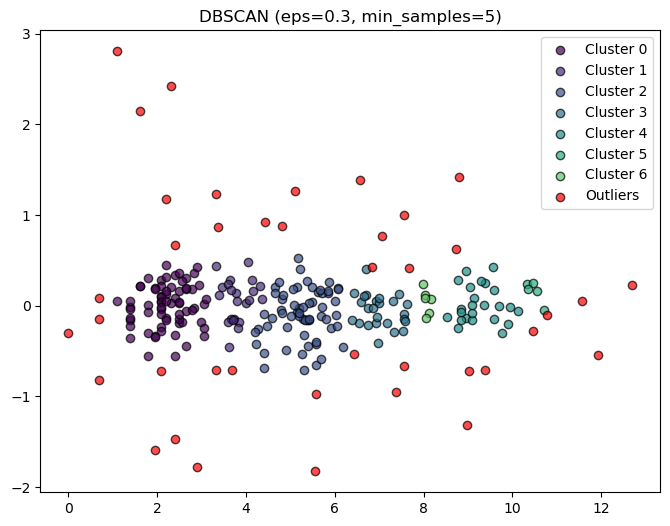

In [105]:
ec_db_labels = db_cluster(ec_pca_embeds, eps=0.3, min_samples=5)

In [81]:
pca = PCA(n_components=2)
hsr_pca_embeds = pca.fit_transform(hsr_feats_and_embeds)
hsr_pca_embeds.shape

(251, 2)

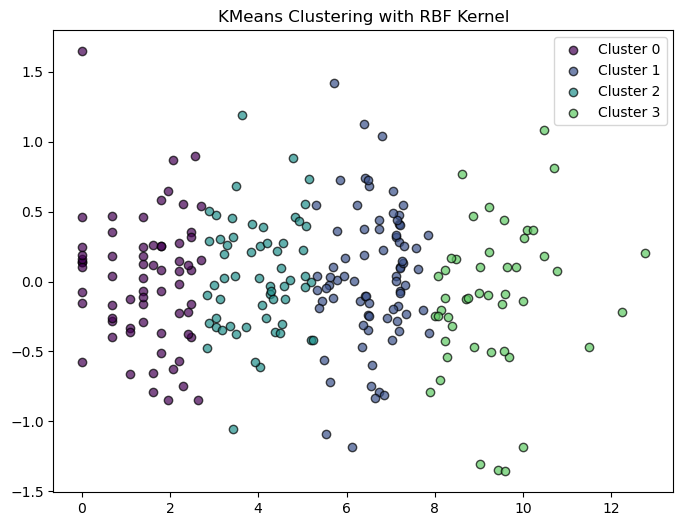

In [82]:
hsr_km_labels = km_cluster(hsr_pca_embeds)

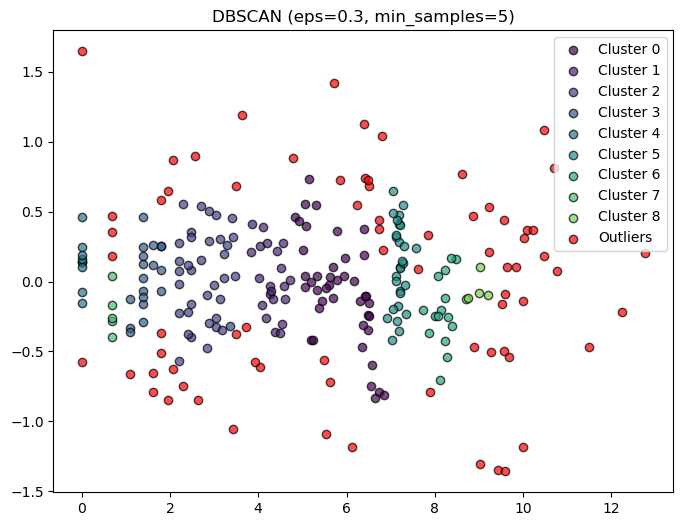

In [106]:
hsr_db_labels = db_cluster(hsr_pca_embeds, eps=0.3, min_samples=5)

In [107]:
def compute_node_properties(data):
    G = to_networkx(data, to_undirected=True)
    
    deg = degree(data.edge_index[0], num_nodes=data.num_nodes).numpy()
    
    clustering = nx.clustering(G)
    
    betweenness = nx.betweenness_centrality(G)
    
    pagerank = nx.pagerank(G)
    
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    df = pd.DataFrame({
        'node_id': list(range(data.num_nodes)),
        'degree': deg,
        'clustering': [clustering[i] for i in range(data.num_nodes)],
        'betweenness': [betweenness[i] for i in range(data.num_nodes)],
        'pagerank': [pagerank[i] for i in range(data.num_nodes)],
        'eigenvector': [eigenvector[i] for i in range(data.num_nodes)]
    })

    return df.set_index('node_id')

ec_prop_df = compute_node_properties(ec_graph.cpu())

In [108]:
ec_prop_df['DB_labels'] = ec_db_labels
ec_prop_df['KM_labels'] = ec_km_labels

ec_prop_df

,degree,clustering,betweenness,pagerank,eigenvector,DB_labels,KM_labels
node_id,,,,,,,
0,135.0,0.535766,0.002236,0.004239,0.066927,0,0
1,132.0,0.500925,0.002485,0.004176,0.063439,0,5
2,127.0,0.505687,0.002262,0.004041,0.061171,0,0
3,93.0,0.514259,0.001181,0.003120,0.044857,0,0
4,99.0,0.507524,0.001454,0.003300,0.045958,0,0
...,...,...,...,...,...,...,...
246,118.0,0.554542,0.001564,0.003768,0.060111,3,7
247,127.0,0.568804,0.001672,0.004002,0.065268,6,7
248,126.0,0.555429,0.001785,0.003983,0.064128,1,3


In [114]:
agg_ec_db = ec_prop_df.drop(columns=['KM_labels']).groupby('DB_labels').median()
agg_ec_db['count'] = ec_prop_df['DB_labels'].value_counts()

agg_ec_db

,degree,clustering,betweenness,pagerank,eigenvector,count
DB_labels,,,,,,
-1,127.0,0.526317,0.002080,0.004032,0.063592,40
0,129.5,0.532136,0.002027,0.004087,0.065094,68
1,124.5,0.532756,0.001939,0.003949,0.061845,22
2,131.0,0.530413,0.002070,0.004140,0.064107,61
3,118.0,0.539476,0.001844,0.003812,0.060111,25
4,123.0,0.536332,0.001795,0.003904,0.062470,24
5,115.0,0.518110,0.001755,0.003709,0.056499,5
6,140.5,0.535490,0.002456,0.004387,0.069847,6


In [117]:
agg_ec_km = ec_prop_df.drop(columns=['DB_labels']).groupby('KM_labels').median()
agg_ec_km['count'] = ec_prop_df['KM_labels'].value_counts()

agg_ec_km

,degree,clustering,betweenness,pagerank,eigenvector,count
KM_labels,,,,,,
0,128.0,0.531712,0.002041,0.004041,0.065334,63
1,129.0,0.535316,0.002057,0.004065,0.064282,25
2,118.0,0.533744,0.001731,0.003781,0.059808,28
3,117.0,0.540220,0.001621,0.003761,0.059181,35
4,132.0,0.526977,0.002197,0.004149,0.066705,51
5,134.0,0.523059,0.002327,0.004208,0.067179,18
6,115.0,0.530836,0.001755,0.003709,0.056499,11
7,128.5,0.536736,0.001912,0.004055,0.064829,20


In [88]:
hsr_prop_df = compute_node_properties(hsr_graph.cpu())
hsr_prop_df['DB_labels'] = hsr_db_labels
hsr_prop_df['KM_labels'] = hsr_km_labels

hsr_prop_df

,degree,clustering,betweenness,pagerank,eigenvector,DB_labels,KM_labels
node_id,,,,,,,
0,129.0,0.521777,0.002046,0.004078,0.064257,-1,2
1,131.0,0.524839,0.002173,0.004136,0.064676,0,2
2,120.0,0.502241,0.001982,0.003850,0.057909,0,2
3,107.0,0.507318,0.001540,0.003495,0.051941,-1,2
4,113.0,0.506005,0.001710,0.003657,0.054990,-1,1
...,...,...,...,...,...,...,...
246,125.0,0.511871,0.002009,0.003971,0.062028,-1,1
247,130.0,0.531544,0.002022,0.004099,0.065277,-1,3
248,126.0,0.514065,0.002012,0.004000,0.062351,0,2


In [119]:
agg_hsr_db = hsr_prop_df.drop(columns=['KM_labels']).groupby('DB_labels').median()
agg_hsr_db['count'] = hsr_prop_df['DB_labels'].value_counts()

agg_hsr_db

,degree,clustering,betweenness,pagerank,eigenvector,count
DB_labels,,,,,,
-1,124.0,0.523074,0.001904,0.003933,0.061684,208
0,131.0,0.511637,0.002173,0.004136,0.064676,7
1,135.0,0.513132,0.002266,0.004237,0.067678,6
2,117.5,0.529902,0.001687,0.003772,0.058110,10
3,130.0,0.516159,0.002302,0.004116,0.063540,12
4,134.0,0.524399,0.002159,0.004207,0.068291,8


In [120]:
agg_hsr_km = hsr_prop_df.drop(columns=['DB_labels']).groupby('KM_labels').median()
agg_hsr_km['count'] = hsr_prop_df['KM_labels'].value_counts()

agg_hsr_km

,degree,clustering,betweenness,pagerank,eigenvector,count
KM_labels,,,,,,
0,124.0,0.528986,0.001920,0.003934,0.062062,67
1,122.0,0.522846,0.001828,0.003890,0.061136,78
2,131.0,0.516297,0.002192,0.004136,0.064257,59
3,121.0,0.523077,0.001829,0.003861,0.060370,47
